In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### 解析数据

In [2]:
data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

In [8]:
train_x = data.drop(['label'], axis=1)
train_y = data['label']

### 可视化

In [3]:
fig_datas = data.drop('label', 1) / 255
label_datas = data['label']

test_fig_datas = test_data / 255

In [56]:
# transform a n*n size series to a n*n data frame 
def transformDataFrameFromSeries(data):
#     df = pd.DataFrame()
    size = int(math.sqrt(data.size))
#     for i in range(size):
#         df = df.append(data.iloc[i * size : (i * size + size)].reset_index(drop=True),ignore_index=True)
    return pd.DataFrame(data.reshape((size, size)))

In [57]:
# show some fig
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = test_fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, label_datas[i]))
plt.tight_layout()
plt.show()

In [107]:
# save some fig
for i in range(500):
    fig_data = fig_datas.iloc[i]
    fig, ax = plt.subplots()
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.savefig('./figs/' + str(i) + '-' + str(label_datas[i]) + '.png')

可以看到不同图的有效区域有差异，同时有些图还有旋转的效果。

有没有必要对数据作进一步降维处理？

直接上random forest试试效果吧

### 训练

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)

rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
test_label_datas = rf.predict(test_data)
test_fig_datas = test_data / 255

In [22]:
# show some fig
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = test_fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, test_label_datas[i]))
plt.tight_layout()
plt.show()

准确率挺厉害的，不过有一个0预测成9了。

In [23]:
submission = pd.DataFrame({
			"ImageId": range(1, test_data.shape[0]+1),
			"label": test_label_datas})
submission.to_csv("random_forest.csv", index=False)

什么参数都没调，数据也没做处理，分数已经达到0.96600。

再试试K近邻模型

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors = 10)

knc.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [25]:
test_label_datas = knc.predict(test_data)

In [26]:
# show some fig
plt.figure(figsize=(18,9))
for i in range(25):
    ax = plt.subplot2grid((5,5),(i / 5, i % 5))
    fig_data = test_fig_datas.iloc[i]
    ax.imshow(transformDataFrameFromSeries(fig_data), cmap=plt.cm.gray_r)
    plt.title('fig %s label:%s' % (i, test_label_datas[i]))
plt.tight_layout()
plt.show()

和随机森林在同一个数据错了，这个0预测成9了……

In [27]:
submission = pd.DataFrame({
			"ImageId": range(1, test_data.shape[0]+1),
			"label": test_label_datas})
submission.to_csv("KNN.csv", index=False)

在kaggle上拿到0.96557分。

### 优化尝试

从数据清洗上看，首先一份向量由784个像素点组成，每个像素点取值范围是0-255，这个样本空间就很大了，而其实每个像素点应该只有两个有效状态，是不是可以尝试对数据进行进一步降维处理。这个预处理需要确定一个阈值来判定像素点是否有效像素（非黑即白），可以按经验固定一个，也可以由每份向量的平均值来确定。


还有是不是可以对图形作“居中”处理，使得距离计算和像素点作为特征更准确。这个貌似需要识别出“有效像素”然后得到“有效图形区域”再平移到画布中点实现居中。

In [48]:
# 计算二维数据frame的中点
def calMeanPointSeries(dataSeries):
    acc_index_x = 0
    acc_index_y = 0
    acc_count = 0
    size = math.sqrt(dataSeries.size)
    for i in range(dataSeries.size):
        if(dataSeries[i] != 0.0):
            # accumulate index
            acc_index_x += (i / size)
            acc_index_y += (i % size)
            acc_count += 1
    return pd.Series([acc_index_x / acc_count, acc_index_y / acc_count])

In [20]:
meanIndexFrame = fig_datas.apply(calMeanPointSeries, axis=1)

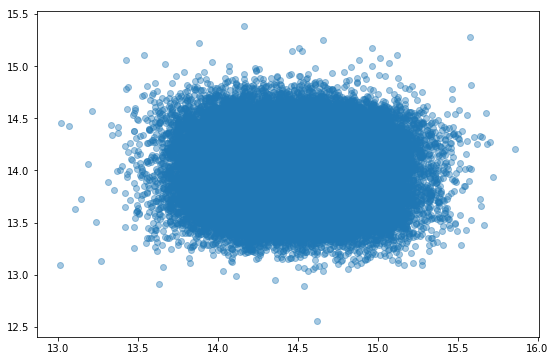

In [22]:
plt.figure(figsize=(9, 6))
plt.scatter(meanIndexFrame[0], meanIndexFrame[1], alpha=0.4, marker='o')
plt.show()

看起来有效点的空间分布上没啥大问题，基本集中在[13.5, 13]-[15.5, 15]之间。再看看有效像素值的分布情况。

In [51]:
# 计算有效像素点的均值和方差
def calPixelDistribution(dataSeries):
    dataSeries = dataSeries[dataSeries != 0.0]
    return pd.Series([dataSeries.mean(), dataSeries.std()])

In [50]:
pixelDisFrame = fig_datas.apply(calPixelDistribution, axis=1)

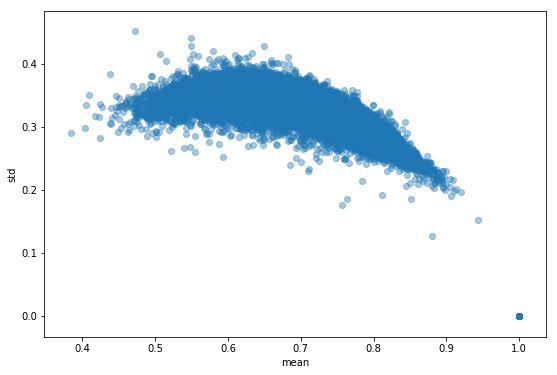

In [57]:
plt.figure(figsize=(9, 6))
plt.scatter(pixelDisFrame[0], pixelDisFrame[1],alpha=0.4, marker='o')
plt.xlabel('mean')
plt.ylabel('std')
plt.show()

总而言之，数据感觉挺干净的，没看出有啥优化清理的空间了……